In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
import os.path
import tensorflow as tf
import numpy as np
from keras.layers import Convolution2D, Lambda
import matplotlib.pyplot as plt
from collections import deque
import random
from gym.wrappers import Monitor
from gym import logger as gymlogger
import tensorflow as tf
import numpy as np
import random
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import keras
from keras.callbacks import TensorBoard
import os
import pandas as pd
import time
from keras.engine.topology import Layer
import shutil
from keras import optimizers,initializers
import cv2
from keras.layers import Input, Dense, Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.models import load_model,Model
from collections import deque 
import gym
from datetime import datetime
from keras.models import clone_model
from skimage.color import rgb2gray
from skimage.transform import resize
import time
from keras import losses
from keras import backend as K

Using TensorFlow backend.


In [0]:
def down_sample(gray):
    return(gray[25::2, ::2])
def dense_to_one_hot(data, depth=10):
    return(np.arange(depth) == np.array(data)[:, None]).astype(np.bool)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
EXPLORATION_STEPS=500000
NUM_ACTIONS=4
BATCH_SIZE=32
STATE_LENGTH=4
SAVE_INTERVAL=200
MEMORY_LOAD=100000
EPSILON_INITIAL=1
EPSILON_FINAL=0.1

def rgb2gray(im):
    return(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)).astype(np.uint8)

LEARNING_RATE_END=5e-6
TRAIN_INTERVAL=4
GAMMA=0.99
TAU=0.001
LEARNING_RATE_START=1e-5
SHAPE=(None,93,80,STATE_LENGTH)
UPDATE_TARGET_NETWORK_INTERVAL=40

In [0]:
class Q_Agent:
    #Initialising the Class
    def __init__(self,root):
        self.batch=deque()
        self.root=root
        self.model_target=Q_Agent.tn_build()
        self.q_out,self.model_train=Q_Agent.net_bt()
        self.epsilon=EPSILON_INITIAL
        self.decay_step=0
        self.learning_rate=LEARNING_RATE_START
        self.episode=1
        self.opt=optimizers.adam(lr=self.learning_rate)
        self.model_train.compile(optimizer=self.opt,loss=[Q_Agent.huber])

    def net_bt():
        mask=Input(shape=(NUM_ACTIONS,), dtype='float32')
        X=Input(shape=SHAPE[1:], dtype='float32')
        model,q_out=Q_Agent.infer(X)
        q_=Lambda(lambda x: K.reshape(K.sum(x * mask, axis=1), (-1, 1)), output_shape=(1,))(q_out)
        return(K.function([X], [q_out]), Model(inputs=[X, mask], outputs=q_))

    #Store Transactions
    def fbat(self, data):
        if(MEMORY_LOAD<=len(self.batch)):
            self.batch.popleft()
        self.batch.append(data)
        return(self.batch)

    #Model saving
    def m_save(self):
        self.model_target.save_weights(os.path.join('/content/gdrive/My Drive/Colab Notebooks/', 'model_target.h5'))
        np.save(os.path.join('/content/gdrive/My Drive/Colab Notebooks/', 'params'), [self.episode, self.decay_step, self.epsilon, self.learning_rate])
        self.model_train.save_weights(os.path.join('/content/gdrive/My Drive/Colab Notebooks/', 'model_train.h5'))

    #Calculate Huber loss
    def huber(x,y):
        loss=K.mean(0.5*K.square(K.clip((K.abs(x-y)),0.0,1.0))+((K.abs(x-y))-(K.clip((K.abs(x - y)),0.0,1.0))), axis=-1)
        return(loss)

    #Batch processing
    def sbat(self):
        q_batch, state_now, mask_b, nxt_sta, rew, done =\
            map(lambda x: np.array(list(x)), zip(*random.sample(self.batch, 32)))
        a=nxt_sta
        nxt_sta=np.transpose(a,axes=[0, 2, 3, 1])
        b=state_now
        state_now=np.transpose(b,axes=[0, 2, 3, 1])
        q_next=self.model_target.predict(nxt_sta)
        mask_b=dense_to_one_hot(mask_b, 4)
        q_batch[mask_b]=np.array(rew) + (GAMMA*np.array(done)*np.max(q_next,axis=1))
        return(q_batch,state_now,mask_b)
    #Predict
    def predict(self, state):
        q=self.q_out([state])
        q=np.array(q).flatten()
        return(np.argmax(q),q)

    #CNN layer
    def infer(X, trainable=True, init=initializers.truncated_normal(stddev=0.01)):
        bi=initializers.constant(0)
        wei=init
        nor=Lambda(lambda x: x / 255., output_shape=K.int_shape(X)[1:])(X)
        #Three Convolution Layers
        #Layer1
        convo1=Convolution2D(32, (8, 8),strides=(4, 4),kernel_initializer=wei,use_bias=False,padding='same',activation='relu')(nor)
        #Layer2
        convo2=Convolution2D(64, (4, 4),strides=(2, 2),kernel_initializer=wei,use_bias=False,padding='same',activation='relu')(convo1)
        #layer3
        convo3=Convolution2D(64, (3, 3),strides=(1, 1),kernel_initializer=wei,use_bias=False,padding='same',activation='relu')(convo2)
        h_flat=Flatten()(convo3)
        fc1=Dense(512, use_bias=False, kernel_initializer=wei,activation='relu')(h_flat)
        z=Dense(NUM_ACTIONS, kernel_initializer=wei, use_bias=False, bias_initializer=bi)(fc1)
        model=Model(inputs=X, outputs=z)
        model.trainable=trainable
        return(model, z)

    #Updating Learning Rate
    def lr_up(self):
        self.learning_rate=self.learning_rate * (0.99 ** (self.decay_step/100))
        self.decay_step+=1
        K.set_value(self.model_train.optimizer.lr, self.learning_rate)

    def tn_build():
        Y=Input(shape=SHAPE[1:], dtype='float32')
        model,Q=Q_Agent.infer(Y, trainable=False, init=initializers.zeros())
        return(model)

    #Updating the Epsilon
    def eps_up(self):
        self.epsilon=np.maximum(EPSILON_FINAL,self.epsilon - (EPSILON_INITIAL - EPSILON_FINAL) / EXPLORATION_STEPS)
     
    #Function Fitting
    def train(self):
        q_batch,state_now,mask_b=self.sbat()
        h=self.model_train.fit([state_now,mask_b],np.sum(mask_b*q_batch, axis=1),verbose=0)
        return(h.history['loss'][0])

    #Restore model
    def res(self):
        self.model_target.load_weights(os.path.join('gdrive/My Drive/Colab Notebooks/', 'model_target.h5'))
        episode, decay_step, eps, learning_rate=np.load(os.path.join('gdrive/My Drive/Colab Notebooks/', 'params.npy'))
        self.model_train.load_weights(os.path.join('gdrive/My Drive/Colab Notebooks/', 'model_train.h5'))
        return(eps, int(episode), learning_rate, int(decay_step))

    #Updating Target network
    def t_net_up(self):
        self.model_target.set_weights(self.model_train.get_weights())

Streaming output truncated to the last 5000 lines.
Episode: 5002, Reward: 6, Epsilon: 0.503465, Loss: 0.002106, learning_rate 0.0000100
Episode: 5003, Reward: 3, Epsilon: 0.503369, Loss: 0.001280, learning_rate 0.0000100
Episode: 5004, Reward: 8, Epsilon: 0.503182, Loss: 0.001741, learning_rate 0.0000100
Episode: 5005, Reward: 7, Epsilon: 0.503011, Loss: 0.002681, learning_rate 0.0000100
Episode: 5006, Reward: 10, Epsilon: 0.502782, Loss: 0.009111, learning_rate 0.0000100
Episode: 5007, Reward: 7, Epsilon: 0.502608, Loss: 0.001194, learning_rate 0.0000100
Episode: 5008, Reward: 10, Epsilon: 0.502406, Loss: 0.037133, learning_rate 0.0000100
Episode: 5009, Reward: 5, Epsilon: 0.502273, Loss: 0.010104, learning_rate 0.0000100
Episode: 5010, Reward: 3, Epsilon: 0.502178, Loss: 0.001666, learning_rate 0.0000100
Episode: 5011, Reward: 4, Epsilon: 0.502068, Loss: 0.001799, learning_rate 0.0000100
Episode: 5012, Reward: 4, Epsilon: 0.501956, Loss: 0.002328, learning_rate 0.0000100
Episode: 501

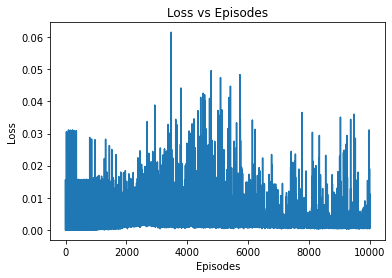

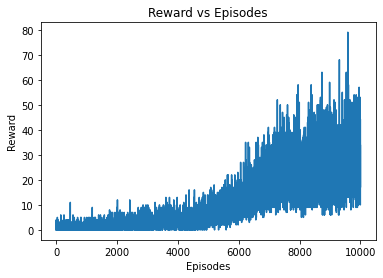

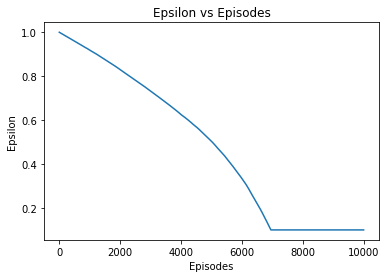

In [13]:
if __name__ == '__main__':
    env=gym.make('BreakoutDeterministic-v4')
    rt='DQN'
    ag=Q_Agent(rt)
    episodes=10000
    i=0
    j=0
    loss_val=[]
    eps_val=[]
    rew_val=[]
    is_done=False
    cnt_frames=0
    while(i<episodes):
        is_done=False
        frame=env.reset()
        frame=down_sample(rgb2gray(frame))
        points=0
        frame_stack=[frame, frame, frame, frame]
        while(not is_done):
            eps=ag.epsilon
            state_current=frame_stack[-4:]
            cnt_frames+=1
            j=np.expand_dims(np.transpose(state_current, [1, 2, 0]), axis=0)
            action,q_current=ag.predict(j)
            if(eps>np.random.random()):
                action=env.action_space.sample()
            frame, reward, is_done, _=env.step(action)
            frame_next=down_sample(rgb2gray(frame))
            points+=reward
            frame_stack.append(frame_next)
            state_next=frame_stack[-4:]
            training_data=(q_current, state_current, action, state_next, np.sign(reward), int(not is_done))
            v=points
            #print(v)
            j=points
            #print(j)
            ag.fbat(training_data)
            if((len(ag.batch)>=BATCH_SIZE) and (cnt_frames%TRAIN_INTERVAL==0)):
                loss=ag.train()
                ag.eps_up()
            frame_stack=frame_stack[-STATE_LENGTH:]
        eps_val.append(eps)
        rew_val.append(points)
        eps=ag.epsilon
        loss_val.append(loss)
        lr=ag.learning_rate
        if((1e-5>np.abs(eps - EPSILON_FINAL)) and (LEARNING_RATE_END<lr)):
            ag.lr_up()
        print('Episode: %d, Reward: %d, Epsilon: %f, Loss: %f, learning_rate %.7f' %(ag.episode,points,eps,loss,lr))
        ag.m_save()
        if(ag.episode % UPDATE_TARGET_NETWORK_INTERVAL==0):
            ag.t_net_up()
        ag.episode += 1
        i+=1

    plt.figure(1)             
    plt.plot(loss_val)
    plt.title('Loss vs Episodes')
    plt.ylabel('Loss')
    plt.xlabel('Episodes')

    plt.figure(2)             
    plt.plot(rew_val)
    plt.title('Reward vs Episodes')
    plt.ylabel('Reward')
    plt.xlabel('Episodes')

    plt.figure(3)             
    plt.plot(eps_val)
    plt.title('Epsilon vs Episodes')
    plt.ylabel('Epsilon')
    plt.xlabel('Episodes')

